# CSC3831 Coursework Part III
#### **Note: You are welcome to run the noteboook, but it is not necessary to run anything, the models take a while to train and the results will not be that much different.**

## Imports

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
from sklearn.model_selection import KFold
from IPython.display import clear_output

## Utility

### Dataset loading

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.data_utils import get_file
from six.moves import cPickle
import os
import sys


def load_cifair10():
    dirname = 'ciFAIR-10'
    archive_name = 'ciFAIR-10.zip'
    origin = 'https://github.com/cvjena/cifair/releases/download/v1.0/ciFAIR-10.zip'
    md5_hash = 'ca08fd390f0839693d3fc45c4e49585f'

    path = get_file(archive_name, origin=origin, file_hash=md5_hash, hash_algorithm='md5', extract=True, archive_format='zip')
    path = os.path.join(os.path.dirname(path), dirname)

    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000:i * 10000, :, :, :],
        y_train[(i - 1) * 10000:i * 10000]) = _load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = _load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    return (x_train, y_train), (x_test, y_test)


def load_cifair100(label_mode='fine'):
    if label_mode not in ['fine', 'coarse']:
        raise ValueError('`label_mode` must be one of `"fine"`, `"coarse"`.')

    dirname = 'ciFAIR-100'
    archive_name = 'ciFAIR-100.zip'
    origin = 'https://github.com/cvjena/cifair/releases/download/v1.0/ciFAIR-100.zip'
    md5_hash = 'ddc236ab4b12eeb8b20b952614861a33'

    path = get_file(archive_name, origin=origin, file_hash=md5_hash, hash_algorithm='md5', extract=True, archive_format='zip')
    path = os.path.join(os.path.dirname(path), dirname)

    fpath = os.path.join(path, 'train')
    x_train, y_train = _load_batch(fpath, label_key=label_mode + '_labels')

    fpath = os.path.join(path, 'test')
    x_test, y_test = _load_batch(fpath, label_key=label_mode + '_labels')

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)


def _load_batch(fpath, label_key='labels'):
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = cPickle.load(f)
            # encode utf8 to ascii
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.encode('utf-8') if isinstance(k, unicode) else k] = v
            d = d_decoded
        else:
            d = cPickle.load(f, encoding='bytes')
            # decode bytes to utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf-8') if isinstance(k, bytes) else k] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


### Plotting

#### Performance

In [28]:
def plot_performance(histories):
    """
    Handles the plotting of the training loss, validation loss, training 
    accuracy, validation accuracy of a model for each fold across all epochs.

    :param histories: list 
                      The history objects (tensorflow.keras.callbacks.History) 
                      produced during each fit of the model.
    """
    fig, ax = plt.subplots(1, len(histories), figsize=(30, 7))

    # Make range out of the number of epochs for the X axis
    epochs = range(1, len(histories[0].history['loss']) + 1)

    # Plot everything

    for i, history in enumerate(histories):
        # Plot training loss
        ax[i].plot(epochs, history.history['loss'], 'ro', label='Training Loss')
        # Plot validation loss
        ax[i].plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
        # Plot training accuracy
        ax[i].plot(epochs, history.history['accuracy'], 'bo', label='Training Accuracy')
        # Plot validation accuracy
        ax[i].plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')

        # Find history's highest value of all metrics to determine how high Y axis goes
        ylim = max(max(history.history['loss']), max(history.history['val_loss']), max(history.history['accuracy']), max(history.history['val_accuracy']))

        # Plot perfect accuracy line (y=1)
        ax[i].hlines(y=1, xmin=[*epochs][0]-1, xmax=[*epochs][-1]+1, linestyle='--', color='gray', alpha=0.5, label='Perfect Accuracy')

        # Set up ticks
        # Round ylim up to the nearest multiple of 0.25
        ax[i].set_ylim(0, np.ceil(ylim / 0.25) * 0.25)
        ax[i].set_xlim(0.5, epochs[-1] + 0.5)
        ax[i].set_yticks(np.arange(0, ax[i].get_ylim()[1] + 0.25, 0.25))
        ax[i].set_xticks(epochs)

        # Set up text
        ax[i].set_title('Model Performance in Fold ' + str(i + 1), fontsize=20)
        ax[i].set_xlabel('Epoch', fontsize=16)
        ax[i].set_ylabel('Value', fontsize=16)

        # Add legend
        ax[i].legend(prop={'size': 12})

    plt.show()

#### Model Comparison

In [11]:
def compare(history_1, history_2, name_1, name_2, time_1, time_2):
    """
    Plots table with comparing the metrics of two models. Uses the data from the
    final epoch of the final fold of the model's training. It also compares the
    TOTAL time it took for a model to complete its entire training (i.e. it 
    includes all epochs and folds).

    :param history_1: tensorflow.keras.callbacks.History
                      The history object produced by the final fit of the first
                      model's training.
    :param history_2: tensorflow.keras.callbacks.History
                      The history object produced by the final fit of the second
                      model's training.
    :param name_1: str
                   The name of the first model, used for the title.
    :param name_2: str
                   The name of the second model, used for the title.
    :param time_1: float
                   Time taken for the first models entire training.
    :param time_2: float
                   Time taken for the first models entire training.
    """
    # Get metrics from the first model
    history_dict_1 = history_1.history

    # Get metrics from the second model
    history_dict_2 = history_2.history

    # Define table
    table = np.zeros([3, 5], dtype=float)

    # Fill table data

    # To help with looping
    metrics = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

    # First line
    for i in range(4):
        table[0, i] = round(history_dict_1[metrics[i]][-1], 3)

    table[0, 4] = round(time_1, 1)
    
    # Second line
    for i in range(4):
        table[1, i] = round(history_dict_2[metrics[i]][-1], 3)

    table[1, 4] = round(time_2, 1)

    # Third line
    for i in range(4):
        table[2, i] = round(100 * (table[1, i] - table[0, i]) /  table[0, i], 2)


    table[2, 4] = round(100 * (time_2 - time_1) / time_1 , 2)

    # Colour-code differences (last line)
    # Good difference for second model -> green
    # Bad difference for second model -> red
    # Tie -> yellow
    colours = []

    for i in range(2):
        if table[2, i] < 0:
            colours.append('#009000')
        else:
            colours.append('#900000')

    for i in range(2, 4):
        if table[2, i] > 0:
            colours.append('#009000')
        else:
            colours.append('#900000')

    if table[2, 4] < 0:
            colours.append('#009000')
    else:
        colours.append('#900000')

    for i in range(5):
      if table[2, i] == 0.0:
        colours[i] = '#DDDD00'
    
    # Plot table
    colLabels = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy', 'Time Taken (s)']
    table = plt.table(cellText=table, rowLabels=[name_1, name_2, '% Difference'], colLabels=colLabels, loc='center', cellLoc='center')
    table.set_fontsize(14)
    table.scale(1.75, 1.75)
    
    # Change last row's cell colours according to colours list and make text 
    # bold to be more readable on coloured background
    for i in range(5):
        table[(3, i)].set_facecolor(colours[i])
        table[(3, i)].set_text_props(fontproperties=FontProperties(weight='bold'))

    plt.title(name_1 + ' - ' + name_2 + 'Comparison', fontsize=20)
    plt.axis('off')

    plt.show()

## Models

### LeNet

In [12]:
def get_lenet_model():
    """
    Creates and compiles a new LeNet model.

    :return model: tensorflow.keras.models.Sequential
                   The LeNet model created.
    """
    # Define the model
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid', padding='same'))
    model.add(tf.keras.layers.AvgPool2D(pool_size=2, strides=2, padding ='same'))
    
    # Second convolutional layer
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid'))
    model.add(tf.keras.layers.AvgPool2D(pool_size=2, strides=2, padding ='same'))
    
    # Fully-connected part
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=120, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(units=84, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### VGGNet

In [13]:
def get_vggnet_model():
    """
    Creates and compiles a new VGGNet model.

    :return model: tensorflow.keras.models.Sequential
                   The VGGNet model created.
    """
    # (number of convolutional layers, number of filters)
    conv_arch = ((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))

    # Define the model
    model = tf.keras.models.Sequential()

    # Add the convolutional layers according to conv_arch
    for (convs, channels) in conv_arch:
        block = tf.keras.models.Sequential()
        for conv in range(convs):
            block.add(tf.keras.layers.Conv2D(channels, kernel_size=3, padding='same', activation='relu'))
        block.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        model.add(block)

    # Add the fully-connected layers
    model.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
        ]))
    
    # Compile the model
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

### ResNet

In [14]:
def get_resnet_model():
    """
    Uses tensorflow's built in functionality to return a ResNet50 model.

    :return model: tensorflow.keras.models.Model
                   The ResNet (ResNet50 specifically) model.
    """
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_base = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3), include_top=False)(resize)

    resnet = tf.keras.layers.GlobalAveragePooling2D()(resnet_base)
    resnet = tf.keras.layers.Flatten()(resnet)
    resnet = tf.keras.layers.Dense(1024, activation="relu")(resnet)
    resnet = tf.keras.layers.Dense(512, activation="relu")(resnet)

    resnet = tf.keras.layers.Dense(10, activation="softmax", name="classification")(resnet)
    model = tf.keras.Model(inputs=inputs, outputs = resnet)
    
    model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model

### Refined LeNet

In [15]:
def get_new_lenet_model():
    """
    Creates and compiles an upgraded version of the LeNet model.

    :return model: tensorflow.keras.models.Sequential
                   The refined LeNet model.
    """
    # Define the model
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding ='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Second convolutional layer
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding ='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Third convolutional layer
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding ='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Fully-connected part
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

## Model Training and Evaluation

In [5]:
# evaluate a model using k-fold cross-validation
def train_model(X_train, y_train, model, n_folds=3, epochs=15):
    """
    Handles k-fold cross validation and model training.

    :param X_train: numpy.ndarray
                    The training data.
    :param y_train: numpy.ndarray
                    The training labels.
    :param model: tensorflow.keras.models.Sequential
                  or
                  tensorflow.keras.models.Model
                  The model to be trained.

    :param n_folds: int
                    Number of folds to perform. Default value n_folds=3.
    :param epochs: int
                   Number of epochs to train for in each fold. Default value
                   epochs=15.

    :return histories: list
                       The history objects (tensorflow.keras.callback.History) 
                       produced during each fit of the model.
    """
    histories = []
    
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # Train folds
    for train_index, test_index in kfold.split(X_train):
        X_train_fold, y_train_fold, X_test_fold, y_test_fold = X_train[train_index], y_train[train_index], X_train[test_index], y_train[test_index]

        # Fit model
        history = model.fit(X_train_fold, y_train_fold, epochs=epochs, verbose=1, validation_data=(X_test_fold, y_test_fold))

        # Store history
        histories.append(history)

    return histories

## Loading the Dataset

First of all, load the dataset.

In [6]:
(X_train, y_train), (X_test, y_test) = load_cifair10()

168615936/168614301 [==============================] - 6s 0us/step


## View Random Images

Let's see what the dataset contains by plotting 10 random images from each class.

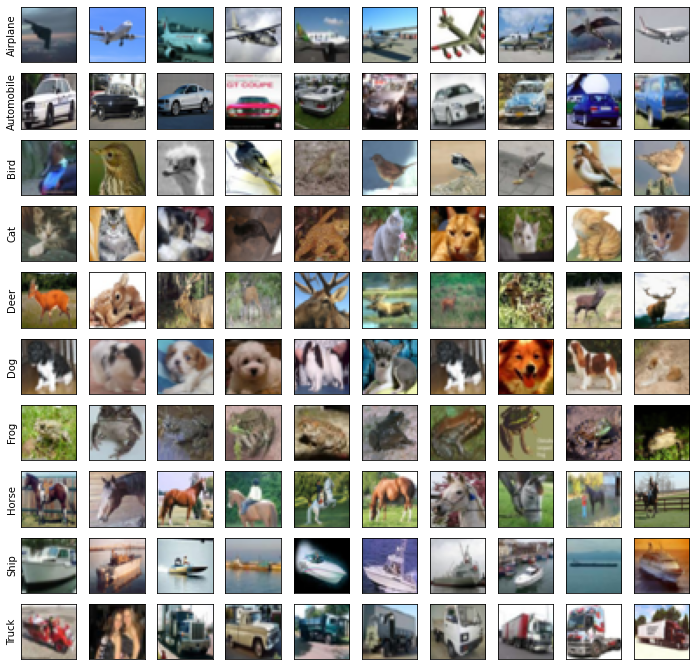

In [16]:
fig, ax = plt.subplots(10, 10, figsize=(12, 12))

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse','Ship', 'Truck']

# Pick images to display
random_images = {}
for i in range(10):
    # Choose 10 random indices from current class
    indices = np.random.choice(np.where(y_train == i)[0], 10)
    # Use indices to pick 10 random images
    random_images[i] = X_train[indices]

# Setup subplots
for i in range(10):
    for j in range(10):
        # Place image
        ax[i, j].imshow(random_images[i][j])
        
        # Remove axis ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
        # Place the class name on the left of each line of images
        if j == 0:
            ax[i, j].set_ylabel(class_names[i])

plt.show()

## Pre-processing

Before we start doing any training, scale our data to be in the [0, 1] range

In [7]:
# Scale images to [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

## Training

This section contains the training of all models except for the refined LeNet model). After training we plot the performance of each model over all epochs in each fold.

### LeNet Model

In [17]:
# Get a LeNet model
LeNet = get_lenet_model()

# Train the model
start_time = time.time()
lenet_histories = train_model(X_train=X_train, y_train=y_train, model=LeNet)
end_time = time.time()

# Clear output
clear_output()

# Calculate time elapsed
lenet_time = end_time - start_time

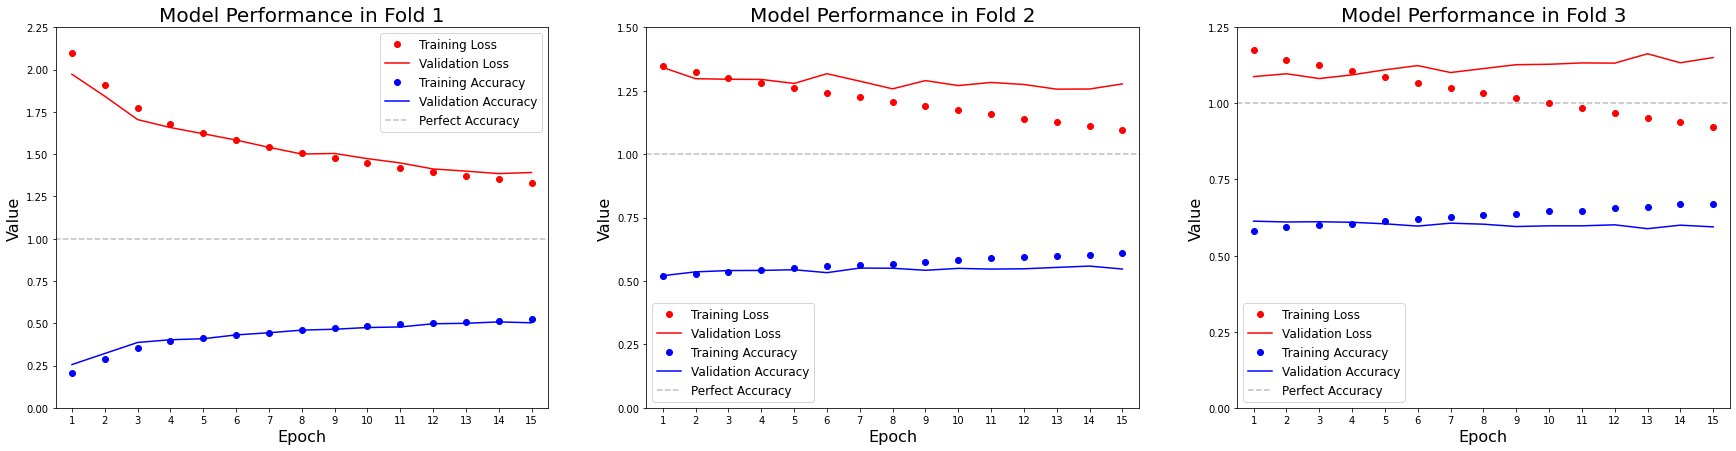

In [18]:
plot_performance(lenet_histories)

The validation accuracy seems to stop growing at ~0.6, which is an unimpressive result and can definitely be improved.

### VGGNet

In [19]:
# Get a VGGNet model
VGGNet = get_vggnet_model()

# Train the model
start_time = time.time()
vggnet_histories = train_model(X_train=X_train, y_train=y_train, model=VGGNet)
end_time = time.time()

# Clear output
clear_output()

# Calculate time elapsed
vggnet_time = end_time - start_time

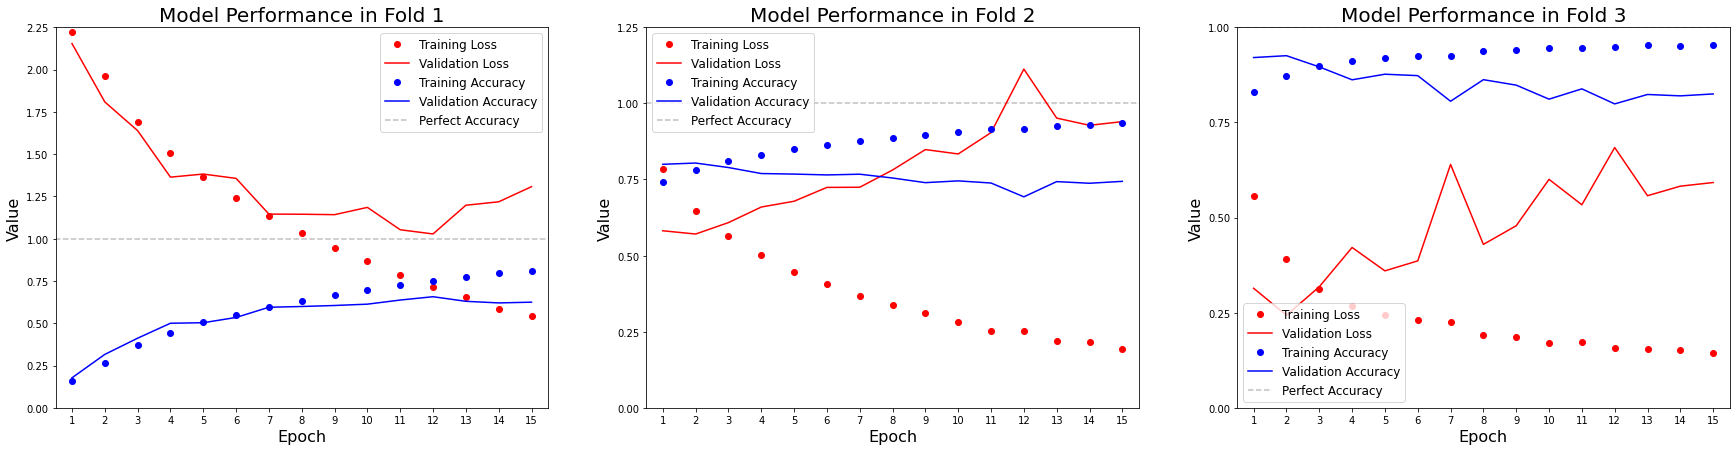

In [20]:
plot_performance(vggnet_histories)

VGGNet gives much better validation accuracy than LeNet, flatting out at ~0.8-0.85 but seems to be overfitting. We can see that in the disparity between validation and training accuracy and even more by the disparity between validation and training loss.

### ResNet

In [10]:
# Get a ResNet model
ResNet = get_resnet_model()

# Train the model - Only 2 folds and 5 epochs, as this model's training takes
# quite a while and it already has good validation accuracy to begin with
start_time = time.time()
resnet_histories = train_model(X_train=X_train, y_train=y_train, n_folds=2, epochs=5, model=ResNet)
end_time = time.time()

# Clear output
clear_output()

# Calculate time elapsed
resnet_time = end_time - start_time

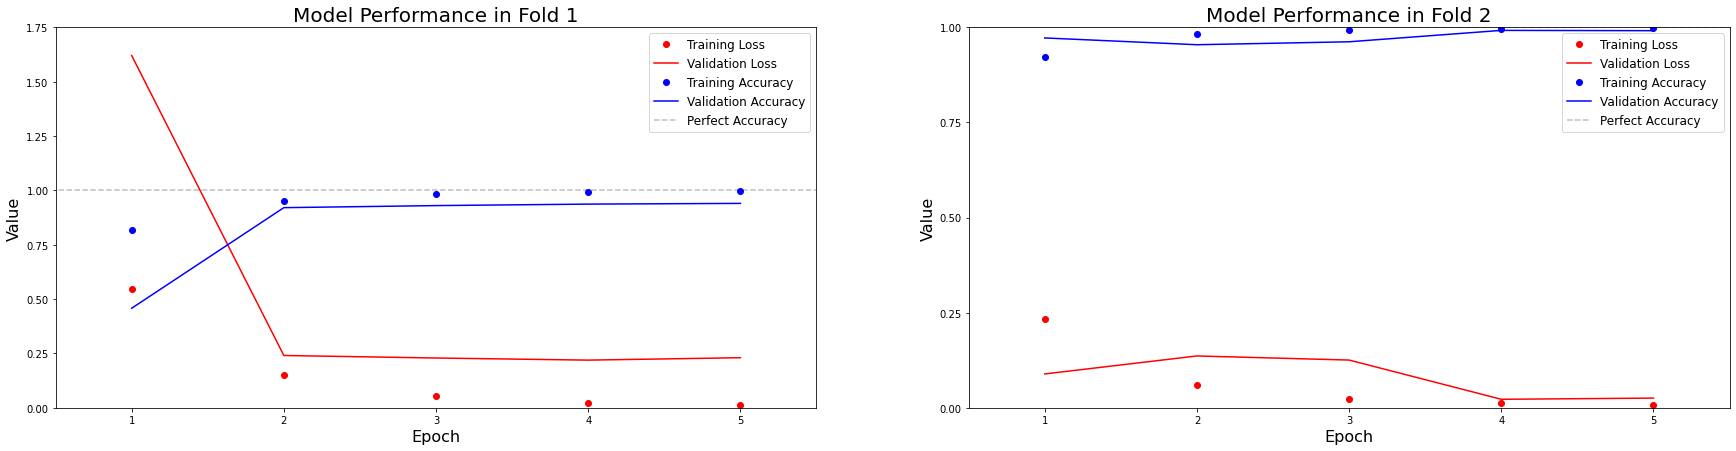

In [29]:
plot_performance(resnet_histories)

ResNet's results are near perfect, with the final validation accuracy being ~0.99. Considering The very low resolution of the images, it is possible this is model does a better job at classifying them than a human. 

## Improving LeNet

Now let's see how the refined LeNet model holds up.

### Training the new LeNet model

In [22]:
# Get a LeNet model
newLeNet = get_new_lenet_model()

# Train the model
start_time = time.time()
newlenet_histories = train_model(X_train=X_train, y_train=y_train, model=newLeNet, epochs=25)
end_time = time.time()

# Clear output
clear_output()

# Calculate elapsed time
newlenet_time = end_time - start_time

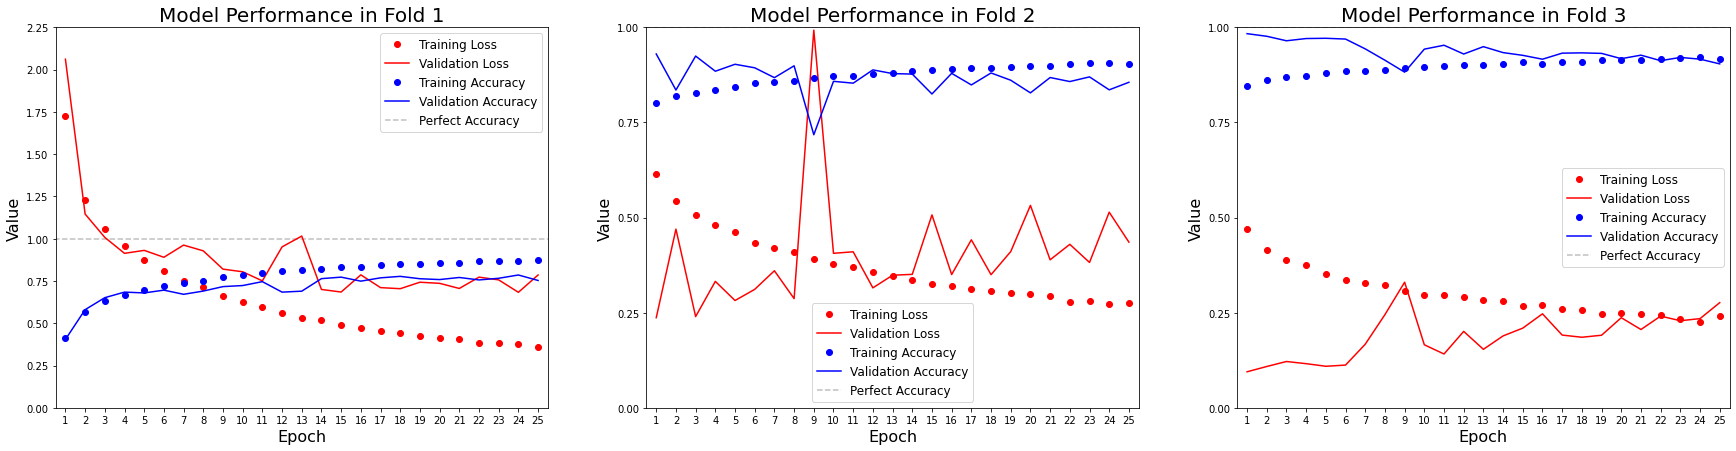

In [23]:
plot_performance(newlenet_histories)

This model gives very nice results, with a validation accuracy of ~0.9. However, there does seem to be some overfitting going on

## Comparison

All models have finished their training, so we can start comparing everything.

### Comparing all base models with each other

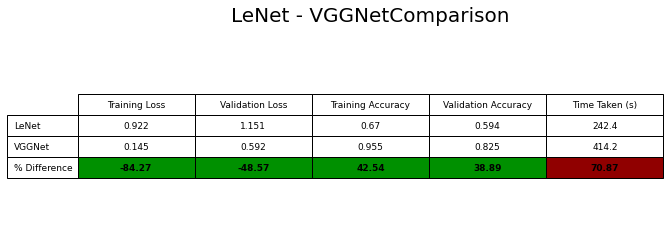

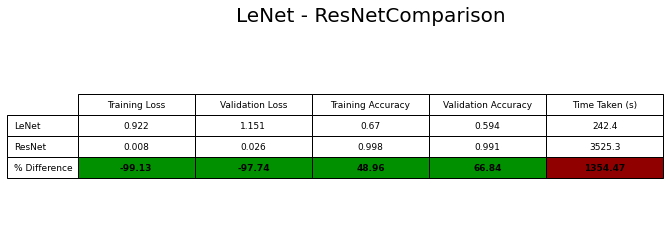

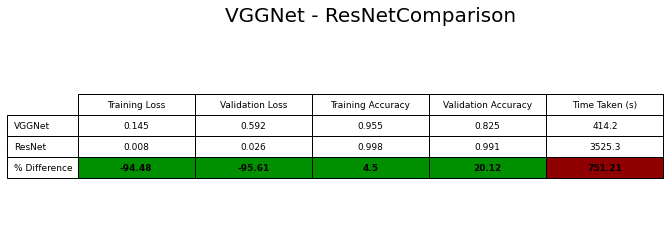

In [24]:
compare(lenet_histories[-1], vggnet_histories[-1], "LeNet", "VGGNet", lenet_time, vggnet_time)
compare(lenet_histories[-1], resnet_histories[-1], "LeNet", "ResNet", lenet_time, resnet_time)
compare(vggnet_histories[-1], resnet_histories[-1], "VGGNet", "ResNet", vggnet_time, resnet_time)

<u>LeNet vs VGGNet:</u>

VGGNet gives much better results in all regards, at the cost of some extra time.

<u>LeNet vs ResNet:</u>

ResNet is a vast improvement over LeNet (no surprise there, ResNet is almost perfect), but takes a lot more time to train.

<u>VGGNet vs ResNet:</u>

Again, ResNet is better, but much slower to train.

### Comparing the base LeNet model to the refined one

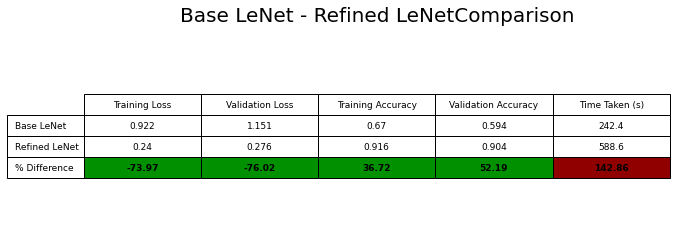

In [25]:
compare(lenet_histories[-1], newlenet_histories[-1], "Base LeNet", "Refined LeNet", lenet_time, newlenet_time)

<u>Base LeNet vs Refined LeNet:</u>

The refined LeNet model gives better results than base LeNet across the board, trading speed in return.

### Comparing the refined LeNet model to the other models

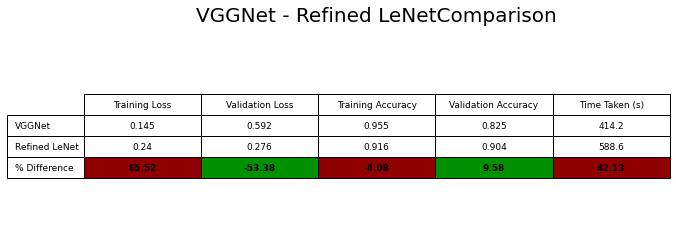

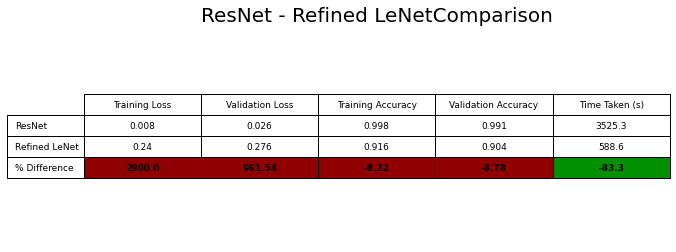

In [26]:
compare(vggnet_histories[-1], newlenet_histories[-1], "VGGNet", "Refined LeNet", vggnet_time, newlenet_time)
compare(resnet_histories[-1], newlenet_histories[-1], "ResNet", "Refined LeNet", resnet_time, newlenet_time)

<u>VGGNet vs Refined LeNet:</u>

VGGNet provides lower training loss and similar training accuracy to refined LeNet but also lower validation loss and accuracy. It is faster, though.

<u>ResNet vs Refined LeNet:</u>

While ResNet does give better results in every category, one could argue that the difference in validation accuracy is not worth the extra time it takes, as it is a lot slower.

## Predicting Images: LeNet Base vs Refined Model

Finally, let's provide some images to the base and refined LeNet models and see how well they manage to classify them.

They will both be provided the same set of 10 images, one from each class.

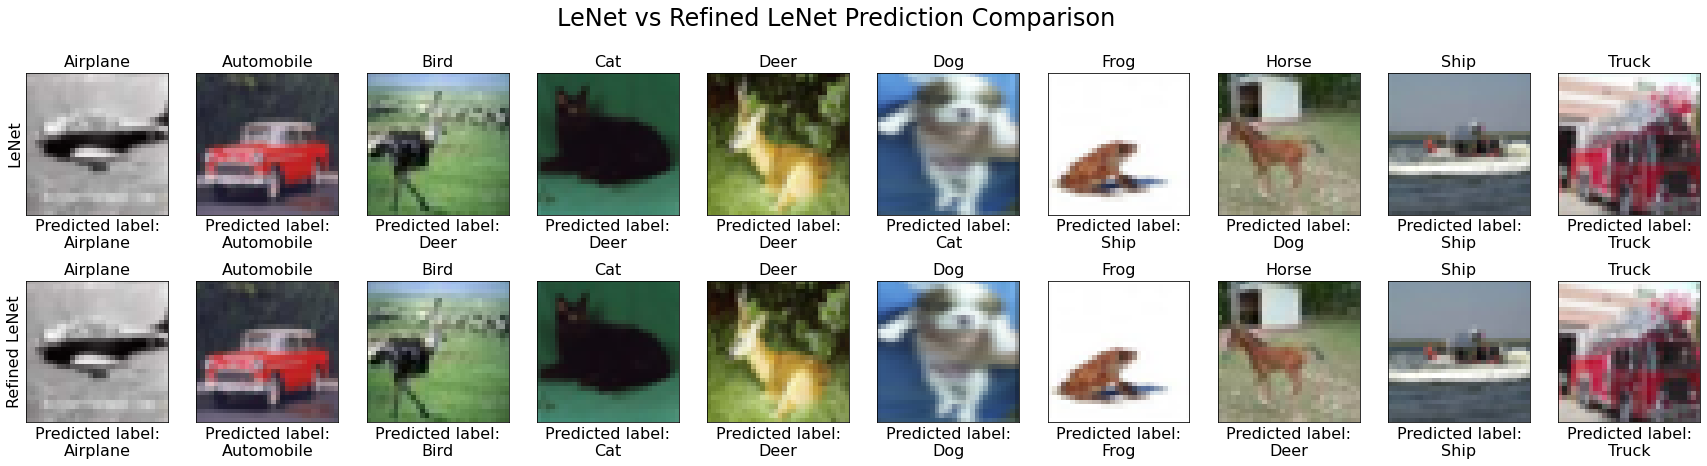

In [27]:
fig, ax = plt.subplots(2, 10, figsize=(30, 7))
fig.suptitle('LeNet vs Refined LeNet Prediction Comparison', fontsize=24)

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse','Ship', 'Truck']

# Pick images to classify
random_images = []
for i in range(10):
    # Choose index of image
    index = np.random.choice(np.where(y_train == i)[0], 10)
    # Add it to the list of images to classify
    random_images.append(X_train[index][0])

# Classification
for i in range(10):
    # Plot the images
    for j in range(2):
        ax[j, i].imshow(random_images[i])
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].set_title(class_names[i], fontsize=16)
    
    # Reshape images to pass to predict() method
    random_images[i] = random_images[i].reshape(1, 32, 32, 3)

    # Perform prediction for each model
    prediction_lenet = class_names[np.argmax(LeNet.predict(random_images[i]))]
    prediction_newlenet = class_names[np.argmax(newLeNet.predict(random_images[i]))]

    # Place model name on the left of each line
    ax[0, 0].set_ylabel('LeNet', fontsize=16)
    ax[1, 0].set_ylabel('Refined LeNet', fontsize=16)

    # Show the predictions under each image
    ax[0, i].set_xlabel(f'Predicted label:\n{prediction_lenet}', fontsize=16)
    ax[1, i].set_xlabel(f'Predicted label:\n{prediction_newlenet}', fontsize=16)

# Clear output
clear_output()

plt.show()

Since there is randomness involved in this, it is possible, though not likely, that the base model manages to classify images more accurately than the refined one, since 60% accuracy vs 90% accuracy does not mean that it will always by 6/10 for one model and 9/10 for the other. If you run this multiple times, however, you will clearly see that refined LeNet performs much better at classifying the images, as you would expect.